# 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
import os
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print('훈련용 데이터: {}개 , 시험 데이터: {}개'.format(len(train_data),len(test_data)))

훈련용 데이터: 150000개 , 시험 데이터: 50000개


# 2) 데이터로더 구성

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# 데이터의 중복 제거
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 


# 한국어 토크나이저로 토큰화
# 불용어(Stopwords) 제거
# 사전word_to_index 구성

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [6]:
# X_train, y_train, X_test, y_test, word_to_index 리턴
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print('훈련데이터: {},   시험데이터: {}'.format(len(X_train), len(X_test)))

훈련데이터: 146182,   시험데이터: 49157


In [10]:
print(X_train[0])
print('라벨: ', y_train[0]) 

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0


In [11]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3) 모델 구성을 위한 데이터 분석 및 가공

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#최대 길이 = (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


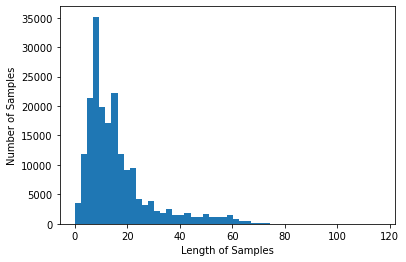

In [13]:
plt.hist(num_tokens, bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됨

그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됨

In [18]:
print(X_train[-1])
print(X_test[-1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  181    5 1945   29    2    8   88 2740    5]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1009  179   63 1058]


In [19]:
print(get_decoded_sentence(X_test[-1], index_to_word))
print('라벨: ', y_test[-1]) 

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 마무리 또 왜 이래
라벨:  0


# 모델링

In [32]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 16 # 워드 벡터의 차원 수

# 4) 모델 구성 및 validation set 구성

In [35]:
x_val = X_train[:10000]   
y_val = y_train[:10000]

partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [36]:
RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(16))   
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
RNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시

In [38]:
RNN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = RNN_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 4s 9ms/step - loss: 0.2745 - accuracy: 0.8853 - val_loss: 0.3215 - val_accuracy: 0.8607
Epoch 2/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2580 - accuracy: 0.8937 - val_loss: 0.3243 - val_accuracy: 0.8624
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2446 - accuracy: 0.8994 - val_loss: 0.3272 - val_accuracy: 0.8613
Epoch 4/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2314 - accuracy: 0.9070 - val_loss: 0.3360 - val_accuracy: 0.8595
Epoch 5/5
266/266 [==============================] - 2s 7ms/step - loss: 0.2191 - accuracy: 0.9122 - val_loss: 0.3518 - val_accuracy: 0.8567


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# 6) Loss, Accuracy 그래프 시각화

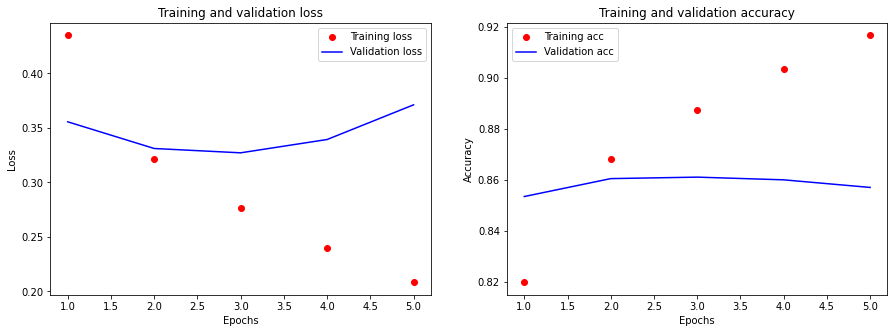

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
# "ro"는 "빨간색 점"
plt.plot(epochs, loss, 'ro', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
results = RNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3788 - accuracy: 0.8541
[0.3788011968135834, 0.8540594577789307]


# 7) 학습된 Embedding 레이어 분석

In [27]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 32)


In [28]:
(10000, 32)
# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/RNNword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씀

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = RNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.05335883, -0.03808449,  0.05857853, -0.10928238,  0.05271229,
        0.06320953, -0.0905374 ,  0.00489029,  0.10564864, -0.02803627,
       -0.05770169, -0.01179082, -0.07438415, -0.13179654,  0.04757476,
       -0.06953134,  0.06218209, -0.01762911, -0.05611585, -0.08342104,
       -0.07373028, -0.03161449,  0.09917663,  0.14406815, -0.0959755 ,
        0.01204953, -0.00634846, -0.06813432,  0.01433918,  0.09380382,
        0.02446672, -0.02307764], dtype=float32)

In [30]:
word_vectors.similar_by_word("실망")

[('지루', 0.9681571125984192),
 ('끊', 0.9655921459197998),
 ('빈약', 0.9625794291496277),
 ('조잡', 0.9615257978439331),
 ('실패작', 0.9586193561553955),
 ('->', 0.9529321193695068),
 ('코스프레', 0.9529312252998352),
 ('피노키오', 0.952063798904419),
 ('잠', 0.9516438245773315),
 ('뜬금없이', 0.9515640139579773)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선